In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns #masuk golongan matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# training properties
DEBUG = True
SEED = 42 #ngambil bibit? yang ke 42
BATCH_SIZE = 64 #ngambil banyaknya data sekali kirim
EPOCHS = 4 if DEBUG else 100000
DATA_DIR = '/content/drive/MyDrive/JanganTidakTahu/HACKATHON/data_telur/dataset'
INPUT_SHAPE = (224, 224, 3)

In [2]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255.0,
    validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    batch_size = BATCH_SIZE,
    seed = SEED,
    target_size=(224, 224),
    class_mode = 'binary',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    shuffle=False, #
    batch_size = BATCH_SIZE,
    seed = SEED,
    target_size=(224, 224),
    class_mode = 'binary',
    subset = 'validation'
)

Found 8112 images belonging to 2 classes.
Found 2026 images belonging to 2 classes.


In [5]:
class_names = train_generator.class_indices #indices = banyak indexxx
class_df = pd.DataFrame.from_dict(class_names, orient='index', columns=['id'])

class_df.to_csv('/content/drive/MyDrive/JanganTidakTahu/HACKATHON/data_telur/classes.csv')
class_df.head()

,id
fertil,0
infertil,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


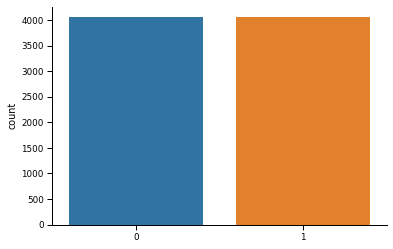

In [8]:
sns.countplot(train_generator.classes)
sns.set_context('paper')
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


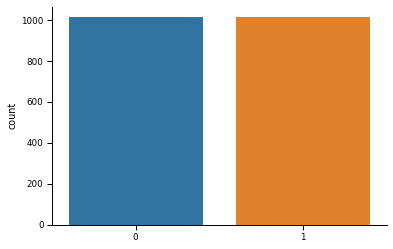

In [9]:
sns.countplot(validation_generator.classes)
sns.set_context('paper')
sns.despine()

In [10]:
model1 = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE) #menghemat waktu running time
model1.trainable = False


input_layer1 = tf.keras.Input(shape=INPUT_SHAPE)

model_layers1 = model1(input_layer1)
model_layers1 = tf.keras.layers.Flatten()(model_layers1)
#output_layer1 = tf.keras.layers.Dense(len(class_df), activation='softmax')(model_layers1)
output_layer1 = tf.keras.layers.Dense(1, activation='sigmoid')(model_layers1)

model1 = tf.keras.Model(input_layer1, output_layer1)

model1.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=10, verbose=0,
      mode='auto', restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.1, patience=3, verbose=0,
      mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001
    )
]
model1.compile(optimizer='Adam',
             loss='binary_crossentropy', #ngitung error
             metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

hist1 = model1.fit(
    train_generator, 
    workers=8, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // BATCH_SIZE)

Epoch 1/4
126/126 [==============================] - 36s 250ms/step - loss: 0.0210 - accuracy: 0.9940 - precision_2: 0.9945 - recall_2: 0.9935 - val_loss: 0.3105 - val_accuracy: 0.9526 - val_precision_2: 0.9346 - val_recall_2: 0.9712
Epoch 2/4
126/126 [==============================] - 32s 243ms/step - loss: 0.0057 - accuracy: 0.9981 - precision_2: 0.9978 - recall_2: 0.9985 - val_loss: 0.3000 - val_accuracy: 0.9602 - val_precision_2: 0.9505 - val_recall_2: 0.9691
Epoch 3/4
126/126 [==============================] - 31s 239ms/step - loss: 0.0058 - accuracy: 0.9985 - precision_2: 0.9985 - recall_2: 0.9985 - val_loss: 0.4018 - val_accuracy: 0.9556 - val_precision_2: 0.9501 - val_recall_2: 0.9598
Epoch 4/4
126/126 [==============================] - 31s 242ms/step - loss: 0.0163 - accuracy: 0.9969 - precision_2: 0.9968 - recall_2: 0.9970 - val_loss: 0.4895 - val_accuracy: 0.9511 - val_precision_2: 0.9856 - val_recall_2: 0.9135


dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'lr'])


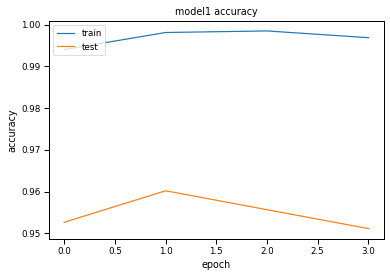

In [15]:
import matplotlib.pyplot as plt

print(hist1.history.keys())
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

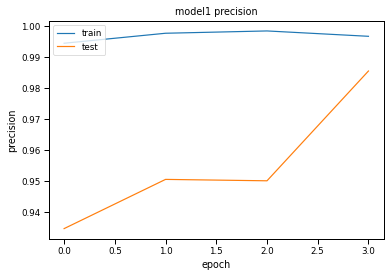

In [18]:
plt.plot(hist1.history['precision_2'])
plt.plot(hist1.history['val_precision_2'])
plt.title('model1 precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist1.history['recall'])
plt.plot(hist1.history['val_recall'])
plt.title('model1 recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
probas = model1.predict(validation_generator)
y_pred = np.argmax(probas, axis=1)
y_true = validation_generator.classes
print(classification_report(y_true,y_pred))

In [19]:
model1.save("/content/drive/MyDrive/JanganTidakTahu/HACKATHON/data_telur/dataset/model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
model = model1.load("/content/drive/MyDrive/JanganTidakTahu/HACKATHON/data_telur/dataset/model.h5")

AttributeError: ignored